In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.base import BaseEstimator

/home/sultan/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
data = pd.read_csv('data/chips.txt', header=None, names=['X', 'Y', 'Class'])

In [4]:
data['Z1'] = abs(data['X'] - data['X'].mean()) + abs(data['Y'] - data['Y'].mean())
data['Z2'] = ((data['X'] - data['X'].mean())**2 + (data['Y'] - data['Y'].mean())**2) ** 0.5

In [15]:
# TODO: It would be a nice idea to implement KNNClassifier
# TODO: using k-d trees.
# accuracy and f1_score usage

def euclidean_metric(x, y):
    return np.linalg.norm(x - y, 2)

def manhattan_metric(x, y):
    return np.linalg.norm(x - y, 1)

def weight0(x, k):
    return k - x

def weight1(x, k):
    return 1./x

def weight2(x, k):
    return 1./(x**2)

def weight3(x, k):
    return 1

def accuracy(y_true, y_pred):
    return (y_true==y_pred).sum() * 1.0 / len(y_true)

def f1_sc(y_true, y_pred):
    tp = ((y_pred == 1) * (y_pred == y_true)).sum()
    fn = ((y_pred == 0) * (y_pred != y_true)).sum()
    fp = ((y_pred == 1) * (y_pred != y_true)).sum()
    rec = tp / (tp + fn)
    prec = tp / (tp + fp)    
    return 2 * prec * rec / (prec + rec)

class KNNClassifier(object):
    def __init__(self, k=1, metric=euclidean_metric, weight=weight0):
        self.k = k
        self.metric = metric
        self.w = weight

    def get_params(self, deep=False):
        return {"k": self.k,
               "metric": self.metric}

    def set_params(self, **params):
        self.k = params["k"]
        self.metric = params["metric"]
    
    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        ys = []
        for x in X:
            order = np.apply_along_axis(lambda y: self.metric(x, y), 1, self.X)
            index = np.argsort(order)
            self.y = self.y[index]
            ws = Counter()
            for ix, v in enumerate(self.y[:self.k]):
                # linearly decreasing weights                
                ws[v] = ws.get(v, 0) + self.w(ix + 1, self.k)
            ys.append(ws.most_common(1)[0][0])
        return np.asarray(ys)
    
    def score(self, X, y, score="accuracy"):
        y_pred = self.predict(X)
        if score == "accuracy":
            return accuracy(y, y_pred)
        elif score == "f1":
            return f1_sc(y, y_pred)
        else:
            raise RuntimeError("unknown score")

In [16]:
# X = data[['X', 'Y', 'Z1', 'Z2']].values
X = data[['X', 'Y']].values
y = data['Class'].values

In [17]:
X = normalize(X)

In [18]:
X_learn, X_holdout, y_learn, y_holdout = train_test_split(X, y, test_size=0.25, random_state=1)
X_train, X_test, y_train, y_test       = train_test_split(X_learn, y_learn, test_size=0.33, random_state=1)

In [19]:
print("Learn size: %d" % X_learn.shape[0])
print("  Train size: %d" % X_train.shape[0])
print("  Test size: %d" % X_test.shape[0])
print("Hold-out size: %d" % X_holdout.shape[0])

Learn size: 88
  Train size: 58
  Test size: 30
Hold-out size: 30


In [20]:
Ks = np.arange(1, 50, 1)

CPU times: user 4.34 s, sys: 0 ns, total: 4.34 s
Wall time: 4.35 s


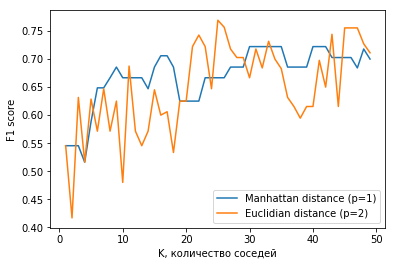

In [23]:
%%time

scores_1 = []
scores_2 = []

for K in Ks:
    knn_1 = KNNClassifier(K, metric=euclidean_metric, weight=weight0)
    knn_2 = KNNClassifier(K, metric=euclidean_metric, weight=weight3)
    knn_1.fit(X_train, y_train)
    knn_2.fit(X_train, y_train)
    scores_1.append(knn_1.score(X_test, y_test, "f1"))
    scores_2.append(knn_2.score(X_test, y_test, "f1"))

plt.xlabel("K, количество соседей")
plt.ylabel("F1 score")
plt.plot(Ks, scores_1, label='Manhattan distance (p=1)')
plt.plot(Ks, scores_2, label='Euclidian distance (p=2)')
plt.legend(loc=0)

CPU times: user 5.26 s, sys: 1.85 s, total: 7.1 s
Wall time: 18.8 s


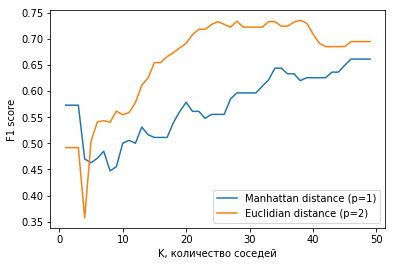

In [27]:
%%time

scores_1 = []
scores_2 = []

for K in Ks:
    cv_score_1 = cross_val_score(KNNClassifier(K, metric=manhattan_metric, weight=weight3), X_learn, y_learn, scoring="f1", cv=5, n_jobs=-1)
    cv_score_2 = cross_val_score(KNNClassifier(K, metric=euclidean_metric, weight=weight3), X_learn, y_learn, scoring="f1", cv=5, n_jobs=-1)
    scores_1.append(np.mean(cv_score_1))
    scores_2.append(np.mean(cv_score_2))

plt.xlabel("K, количество соседей")
plt.ylabel("F1 score")
plt.plot(Ks, scores_1, label='Manhattan distance (p=1)')
plt.plot(Ks, scores_2, label='Euclidian distance (p=2)')
plt.legend(loc=0)

In [13]:
K = 7
knn = KNNClassifier(K)
knn.fit(X_learn, y_learn)
print("Hold-out score (K=%d): %.2f" % (K, knn.score(X_holdout, y_holdout, "f1")))

Hold-out score (K=7): 0.52
